## Illustrate usage of DAPPER to (interactively) run a synthetic ("twin") experiment.

#### Imports
<b>NB:</b> On <mark><b>Gooble Colab</b></mark>,
*replace* `%matplotlib notebook` (right below) by\
`!python -m pip install git+https://github.com/nansencenter/DAPPER.git`

In [1]:
%matplotlib notebook
from mpl_tools import is_notebook_or_qt as nb

In [2]:
import dapper as dpr
import dapper.da_methods as da

/home/jbris/miniconda3/envs/data_assim/lib/python3.10/site-packages/dapper/tools/progressbar.py:140: UserWarning: Keyboard interaction (to skip/stop/pause the liveplotting) does not work in the current python frontend. If you wish, you can use dpr_config.yaml to disable the liveplotting altogether, which will silence this message.
  _interaction_impossible()


#### Load experiment setup: the hidden Markov model (HMM)

In [3]:
from dapper.mods.Lorenz63.sakov2012 import HMM

#### Generate the same random numbers each time this script is run

In [4]:
dpr.set_seed(3000)

3000

#### Simulate synthetic truth (xx) and noisy obs (yy)

In [5]:
HMM.tseq.T = 30  # shorten experiment
xx, yy = HMM.simulate()

Truth & Obs:   0%|                                                      | 0/3000 [00:00<?, ?it/s]

#### Specify a DA method configuration ("xp" is short for "experiment")

In [6]:
# xp = da.OptInterp()
# xp = da.Var3D()
# xp = da.ExtKF(infl=90)
xp = da.EnKF('Sqrt', N=10, infl=1.02, rot=True)
# xp = da.PartFilt(N=100, reg=2.4, NER=0.3)

#### Assimilate yy, knowing the HMM; xx is used to assess the performance

In [7]:
xp.assimilate(HMM, xx, yy, liveplots=not nb)

EnKF:   0%|                                                             | 0/3000 [00:00<?, ?it/s]

#### Average the time series of various statistics

In [8]:
# print(xp.stats)  # ⇒ long printout
xp.stats.average_in_time()

#### Print some of these time-averages

In [9]:
# print(xp.avrgs)  # ⇒ long printout
print(xp.avrgs.tabulate(['rmse.a', 'rmv.a']))

rmse.a  1σ   rmv.a  1σ  
-----------  -----------
   0.7 ±0.2   0.65 ±0.03


#### Replay liveplotters

Initializing liveplots...


<IPython.core.display.Javascript object>


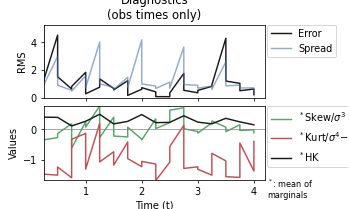

<IPython.core.display.Javascript object>


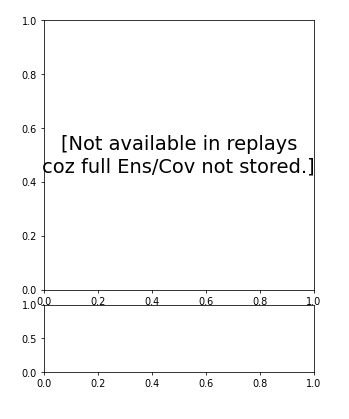

<IPython.core.display.Javascript object>


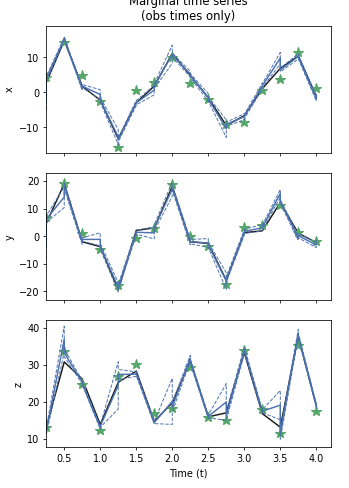

<IPython.core.display.Javascript object>


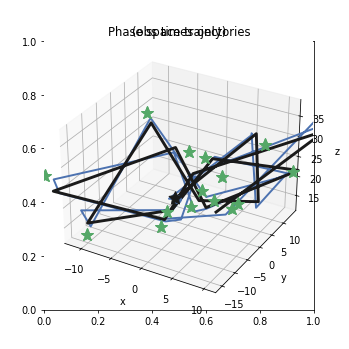

EnKF (replay):   0%|                                                    | 0/3000 [00:00<?, ?it/s]

In [10]:
xp.stats.replay(
    # speed=.6  # `speed` does not work in notebooks
)

#### Further diagnostic plots

<IPython.core.display.Javascript object>


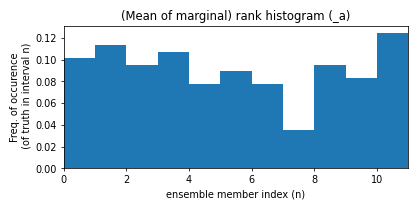

<IPython.core.display.Javascript object>


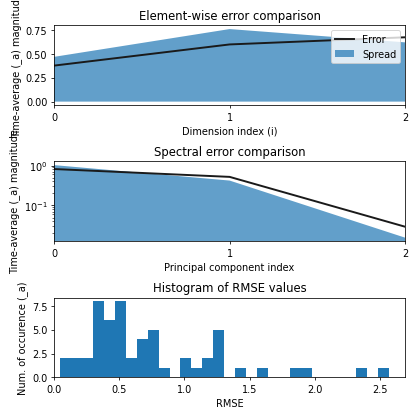

<IPython.core.display.Javascript object>


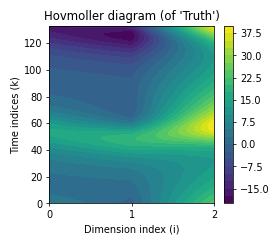

In [11]:
if nb:
    import dapper.tools.viz as viz
    viz.plot_rank_histogram(xp.stats)
    viz.plot_err_components(xp.stats)
    viz.plot_hovmoller(xx)

#### Explore objects

In [12]:
if nb:
    print(xp)

EnKF(upd_a='Sqrt', N=10, infl=1.02, rot=True, fnoise_treatm='Stoch')


In [13]:
if nb:
    print(HMM)


  - Dyn: 
    ¦     - M: 3
    ¦     - model: rk4 integration of <function dapper.mods.Lorenz63.dxdt(x)>
    ¦     - noise:
    ¦       ¦     - mu: [0. 0. 0.]
    ¦       ¦     -  M: 3
    ¦       ¦     -  C: 0
    ¦     - linear: <function dstep_dx at 0x7f1b45563b50>
  - Obs: 
    ¦     - M: 3
    ¦     - model: Direct obs. at [0 1 2]
    ¦     - noise:
    ¦       ¦     -  C: <CovMat>
    ¦       ¦         ¦       M: 3
    ¦       ¦         ¦    kind: 'diag'
    ¦       ¦         ¦   trunc: 1.0
    ¦       ¦         ¦      rk: 3
    ¦       ¦         ¦    full:
    ¦       ¦         ¦      [[2. 0. 0.]
    ¦       ¦         ¦       [0. 2. 0.]
    ¦       ¦         ¦       [0. 0. 2.]]
    ¦       ¦         ¦    diag:
    ¦       ¦         ¦       [2. 2. 2.]
    ¦       ¦     - mu: [0. 0. 0.]
    ¦       ¦     -  M: 3
    ¦     - linear:
    ¦       ¦   Constant matrix
    ¦       ¦   [[1. 0. 0.]
    ¦       ¦    [0. 1. 0.]
    ¦       ¦    [0. 0. 1.]]
    ¦     - localizer:
    ¦     

#### Excercise: Why are the replay plots not as smooth as the liveplot?
*Hint*: provide the keyword `store_u=True` to `assimilate()` to avoid this.

#### Excercise: Why does the replay only contain the blue lines?

#### Excercise: Try out each of the above DA methods (currently commented out).
Next, remove the call to `replay`, and set `liveplots=False` above.
Now, use the iterative EnKS (`iEnKS`), and try to find a parameter combination
for it so that you achieve a lower `rmse.a` than with the `PartFilt`.

*Hint*: In general, there is no free lunch. Similarly, not all methods work
for all problems; additionally, methods often have parameters that require
tuning. Luckily, in DAPPER, you should be able to find suitably tuned
configuration settings for various DA methods *in the files that define the
HMM*. If you do not find a suggested configuration for a given method, you
will have to tune it yourself. The example script `basic_2` shows how DAPPER
facilitates the tuning process, and `basic_3` takes this further.

#### Excercise: Run an experiment for each of these models
- LotkaVolterra
- Lorenz96
- LA
- QG

#### Excercise: Printing other diagnostics.
- Create a new code cell, and copy-paste the above `print(...tabulate)`
  command into it. Then, replace `rmse` by `err.rms`. This should yield
  the same printout, as is merely an abbreviation of the latter.
- Next, figure out how to print the time average *forecast (i.e. prior)* error
  (and `rmv`) instead. Explain (in broad terms) why the values are larger than
  for the *analysis* values.
- Finally, instead of the `rms` spatial/field averages,
  print the regular mean (`.m`) averages. Explain why `err.m` is nearly zero,
  in contrast to `err.rms`.